# WDSS Football Forecasting Competition

## The Competition

## The Rules

## The Winner & Prize

# Getting Started: a demo model

Here we provide a baseline model for our upcoming Premier League forecasting competition.

In [1]:
# Dependencies
from scipy.stats import poisson, skellam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Gathering our data

In [2]:
#### FUNCTION TO RETRIEVE PREMIER LEAGUE DATA ####
def get_premier_league_data(start_year):
    """
    
    Function to get Premier League data
    :int start_year: Takes in the starting year of the season
    
    """
    season = str(start_year)[-2:] + str(start_year+1)[-2:]
    data = pd.read_csv("http://www.football-data.co.uk/mmz4281/" + season + "/E0.csv")
    return data

In [8]:
# Get data from the 2018/2019 season 
data = get_premier_league_data(2018)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


## Light cleaning

In [4]:
# Filtering and renaming columns of interest
columns = ['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR']
data = data[columns].rename(columns={'FTHG': 'HomeGoals', 
                                     'FTAG': 'AwayGoals', 
                                     'FTR':'Result'})

In [5]:
# Remove final week of fixtures
data = data[:-10] 

## Simple analysis: Home team advantage?


In [7]:
# Compute the average number of home and away goals
data[['HomeGoals', 'AwayGoals']].mean()

HomeGoals    1.575676
AwayGoals    1.224324
dtype: float64

## Towards a match prediction model 

- One way to predict the match score is to consider the number of goals scored by each team
- We will denote the number of home team goals by $y_i$ where $i$ indicates the particular match
- Furthermore, we will use *regression analysis* to model $\mathbb{E}[y_i | X_i]$ 

## The Poisson distribution

- The Poisson distribution is often used to model the probability that some event will happen  

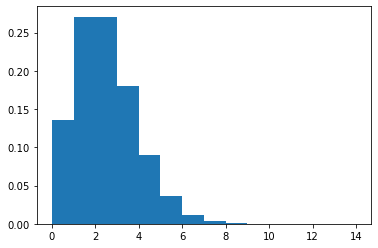

In [29]:
x = np.random.poisson(2, 100000000)
plt.hist(x, 14, density=True)
plt.show()

In [7]:
# Prepare the dataset
# Separate home and away teams/goals - then concatenate
goal_model_data = pd.concat([epl_1819[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1819[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [8]:
# Building the model
# Poisson Regression: log-linear model
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

In [9]:
# Get a statistical summary of the poisson model
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1030.1
Date:                Sun, 26 Sep 2021   Deviance:                       732.30
Time:                        12:06:36   Pearson chi2:                     634.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.4925      0.192      2.572      0.010       0.117       0.868
team[T.Bournemouth]           -0.2703      0.183     -1.481      0.139      -0.628       0.087
team[T.Brighton]              -0.7334      0.209     -3.503      0.000      -1.144      -0.323
team[T.Burnley]               -0.4493      0.192     -2.334      0.020      -0.827      -0.072
team[T.Cardiff]               -0.7702      0.214     -3.603      0.000      -1.189      -0.351
team[T.Chelsea]               -0.1249      0.174     -0.718      0.473      -0.466       0.216
team[T.Crystal Palace]        -0.4125      0.190     -2.169      0.030      -0.785      -0.040
team[T.Everton]               -0.3165      0.183     -1.726      0.084      -0.676       0.043
team[T.Fulham]                -0.6986      0.209     -3.335      0.001      -1.109      -0.288
team[T.Huddersfield]          -1.1820      0.249     -4.744      0.000      -1.670      -0.694
team[T.Leicester]             -0.3261      0.184     -1.768      0.077      -0.688       0.035
team[T.Liverpool]              0.1849      0.161      1.149      0.251      -0.130       0.500
team[T.Man City]               0.2291      0.159      1.438      0.150      -0.083       0.541
team[T.Man United]            -0.0621      0.173     -0.360      0.719      -0.401       0.276
team[T.Newcastle]             -0.6104      0.202     -3.024      0.002      -1.006      -0.215
team[T.Southampton]           -0.4387      0.193     -2.275      0.023      -0.817      -0.061
team[T.Tottenham]             -0.0917      0.173     -0.531      0.595      -0.430       0.247
team[T.Watford]               -0.3106      0.185     -1.683      0.092      -0.672       0.051
team[T.West Ham]              -0.3788      0.188     -2.017      0.044      -0.747      -0.011
team[T.Wolves]                -0.4239      0.189     -2.244      0.025      -0.794      -0.054
opponent[T.Bournemouth]        0.2458      0.189      1.303      0.192      -0.124       0.615
opponent[T.Brighton]           0.0890      0.195      0.456      0.648      -0.293       0.471
opponent[T.Burnley]            0.2413      0.188      1.282      0.200      -0.128       0.610
opponent[T.Cardiff]            0.2950      0.186      1.585      0.113      -0.070       0.660
opponent[T.Chelsea]           -0.2537      0.214     -1.185      0.236      -0.673       0.166
opponent[T.Crystal Palace]    -0.0269      0.200     -0.134      0.893      -0.420       0.366
opponent[T.Everton]           -0.1366      0.207     -0.659      0.510      -0.543       0.269
opponent[T.Fulham]             0.3861      0.182      2.121      0.034       0.029       0.743
opponent[T.Huddersfield]       0.3551      0.183      1.941      0.052      -0.003       0.714
opponent[T.Leicester]         -0.0595      

### Simulation & Validation

In [33]:
# Build a function to simulate a match using the newly generated poisson model
# Outputs the probability distribution 
# Considers 8 goals as a maximum for either team

def simulate_match(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


simulate_match('Chelsea', 'Man City')

array([[8.84524074e-02, 1.41227448e-01, 1.12745332e-01, 6.00049071e-02,
        2.39516937e-02, 7.64848957e-03, 2.03532554e-03, 4.64242926e-04,
        9.26541255e-05],
       [7.32953480e-02, 1.17026944e-01, 9.34254767e-02, 4.97225646e-02,
        1.98473708e-02, 6.33785694e-03, 1.68655549e-03, 3.84691020e-04,
        7.67770666e-05],
       [3.03677887e-02, 4.84866995e-02, 3.87081201e-02, 2.06010938e-02,
        8.22317894e-03, 2.62590609e-03, 6.98775055e-04, 1.59385499e-04,
        3.18103372e-05],
       [8.38800475e-03, 1.33926994e-02, 1.06917200e-02, 5.69030804e-03,
        2.27135616e-03, 7.25311709e-04, 1.93011369e-04, 4.40244871e-05,
        8.78645666e-06],
       [1.73766250e-03, 2.77443710e-03, 2.21490111e-03, 1.17880655e-03,
        4.70535074e-04, 1.50255871e-04, 3.99843144e-05, 9.12013080e-06,
        1.82020597e-06],
       [2.87979901e-04, 4.59802822e-04, 3.67071858e-04, 1.95361638e-04,
        7.79809911e-05, 2.49016543e-05, 6.62653357e-06, 1.51146403e-06,
        3.0

In [11]:
# Similar function, selecting most probable scoreline

def simulate_match_output(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # multiply distributions together
    
    # Get most likely score from the matrix
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    output = homeTeam + ": " + str(h) + "\n" + awayTeam + ": " + str(a)
    
    return print(output)
    return(h, a)

simulate_match_output('Chelsea', 'Man City')

Chelsea: 0
Man City: 1


In [12]:
# Similar function, built to be iterated

def simulate_match_clean(homeTeam, awayTeam, max_goals=8, foot_model=poisson_model):
    # Predict avg goals
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    distribution = np.outer(np.array(team_pred[0]), np.array(team_pred[1])) # *multiply distributions together
    
    # Get most likely score
    global h, a
    h = np.argmax(distribution)//(max_goals + 1) 
    a = np.argmax(distribution)%(max_goals + 1) 
    
    return(h, a)

simulate_match_clean('Chelsea', 'Man City')

(0, 1)

In [13]:
# Simulate matches for any given PL seaason
# Takes in dataset as input

def simulate_test(x):
    
    data = x.copy()
    
    data['HomePred'] = [0] * len(data)
    data['AwayPred'] = [0] * len(data)
    
    for i in range(len(data)):
        homeTeam = data['HomeTeam'][i]
        awayTeam = data['AwayTeam'][i]
        
        simulate_match_clean(homeTeam, awayTeam)
        data.loc[i, 'HomePred'] = int(h)
        data.loc[i, 'AwayPred'] = int(a)
    
    data = pd.DataFrame.from_dict(data)
    
    return(data)

epl_1819_post = simulate_test(epl_1819)
epl_1819_post

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred
0,Man United,Leicester,2,1,H,1,1
1,Bournemouth,Cardiff,2,0,H,2,0
2,Fulham,Crystal Palace,0,2,A,1,1
3,Huddersfield,Chelsea,0,3,A,0,2
4,Newcastle,Tottenham,1,2,A,0,1
...,...,...,...,...,...,...,...
365,Wolves,Fulham,1,0,H,2,0
366,Arsenal,Brighton,1,1,D,2,0
367,Chelsea,Watford,3,0,H,1,0
368,Huddersfield,Man United,1,1,D,0,2


In [14]:
type(epl_1819_post['AwayPred'][2])

numpy.int64

In [15]:
# Add prediction results column
# NOT WORKING - Does not register draws

def update_df_res(data):
    
    ResultPred = []
    
    for i in data['HomePred']:
        if i == data['AwayPred'][i]:
            ResultPred.append('D')
        elif i < data['AwayPred'][i]:
            ResultPred.append('A')
        else:
            ResultPred.append('H')
        
    data = pd.concat([data, pd.Series(ResultPred)], axis=1).rename({0: 'ResultPred'}, axis =1)
    
    return data

In [16]:
# Validate full time result prediction

def update_df_ftr(data):    
    
    correctFTR = []
    
    for i in range(len(data)):
        if str(data['ResultPred'][i]) is str(data['Result'][i]):
            correctFTR.append(True)
        else:
            correctFTR.append(False)
        
    data = pd.concat([data, pd.Series(correctFTR)], axis=1).rename({0: 'correctFTR'}, axis =1)
    
    return data

In [17]:
# Vallidate Scoreline Prediction

def update_df_correct(data):    
    
    correctScore = []

    for i in range(len(data)):
        if data['HomeGoals'][i] == data['HomePred'][i] and data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append(True)
        elif data['HomeGoals'][i] == data['HomePred'][i]:
            correctScore.append('Home')
        elif data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append('Away')
        else:
            correctScore.append(False)

    data = pd.concat([data, pd.Series(correctScore)], axis=1).rename({0: 'correctScore'}, axis =1)
    
    return data

In [18]:
epl_1819_post = update_df_correct(epl_1819_post)

In [19]:
epl_1819_post.columns

Index(['HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'Result', 'HomePred',
       'AwayPred', 'correctScore'],
      dtype='object')

In [20]:
# Add validation columns
# NOT WORKING - Does not take into account draws

def update_df(data):
    
    ResultPred = []
    
    for i in data['HomePred']:
        if int(i) > int(data['AwayPred'][i]):
            ResultPred.append('H')
        elif int(i) == int(data['AwayPred'][i]):
            ResultPred.append('D')
        else:
            ResultPred.append('A')
        
    data = pd.concat([data, pd.Series(ResultPred)], axis=1).rename({0: 'ResultPred'}, axis =1)
    
    correctFTR = []
    
    for i in range(len(data)):
        if str(data['ResultPred'][i]) is str(data['Result'][i]):
            correctFTR.append(True)
        else:
            correctFTR.append(False)
        
    data = pd.concat([data, pd.Series(correctFTR)], axis=1).rename({0: 'correctFTR'}, axis =1)
    
    correctScore = []

    for i in range(len(data)):
        if data['HomeGoals'][i] == data['HomePred'][i] and data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append(True)
        elif data['HomeGoals'][i] == data['HomePred'][i]:
            correctScore.append('Home')
        elif data['AwayGoals'][i] == data['AwayPred'][i]:
            correctScore.append('Away')
        else:
            correctScore.append(False)

    data = pd.concat([data, pd.Series(correctScore)], axis=1).rename({0: 'correctScore'}, axis =1)
    
    return data

#epl_1819_post = update_df(epl_1819_post)

In [21]:
epl_1819_post.head(20)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,HomePred,AwayPred,correctScore
0,Man United,Leicester,2,1,H,1,1,Away
1,Bournemouth,Cardiff,2,0,H,2,0,True
2,Fulham,Crystal Palace,0,2,A,1,1,False
3,Huddersfield,Chelsea,0,3,A,0,2,Home
4,Newcastle,Tottenham,1,2,A,0,1,False
5,Watford,Brighton,2,0,H,1,0,Away
6,Wolves,Everton,2,2,D,1,1,False
7,Arsenal,Man City,0,2,A,0,2,True
8,Liverpool,West Ham,4,0,H,2,0,Away
9,Southampton,Burnley,0,0,D,1,1,False


In [22]:
# Total correct final outcomes
epl_1819_post['correctScore'].value_counts()

False    152
Away     103
Home      77
True      38
Name: correctScore, dtype: int64

In [23]:
# At least one correct prediction (home, away or both)
sum(epl_1819_post['correctScore'].value_counts()[-3:])

218

In [24]:
# Most common incorrect predictions (Draws seem prety common here?!)
#epl_1819_post2 = epl_1819_post[epl_1819_post['correctFTR'] == False]
#epl_1819_post2['ResultPred'].value_counts()

# WILL NOT WORK UNTIL DRAWS ARE ACCOUNTED FOR

### Plots

In [35]:
chelsea_mancity = simulate_match('Chelsea', 'Man City')

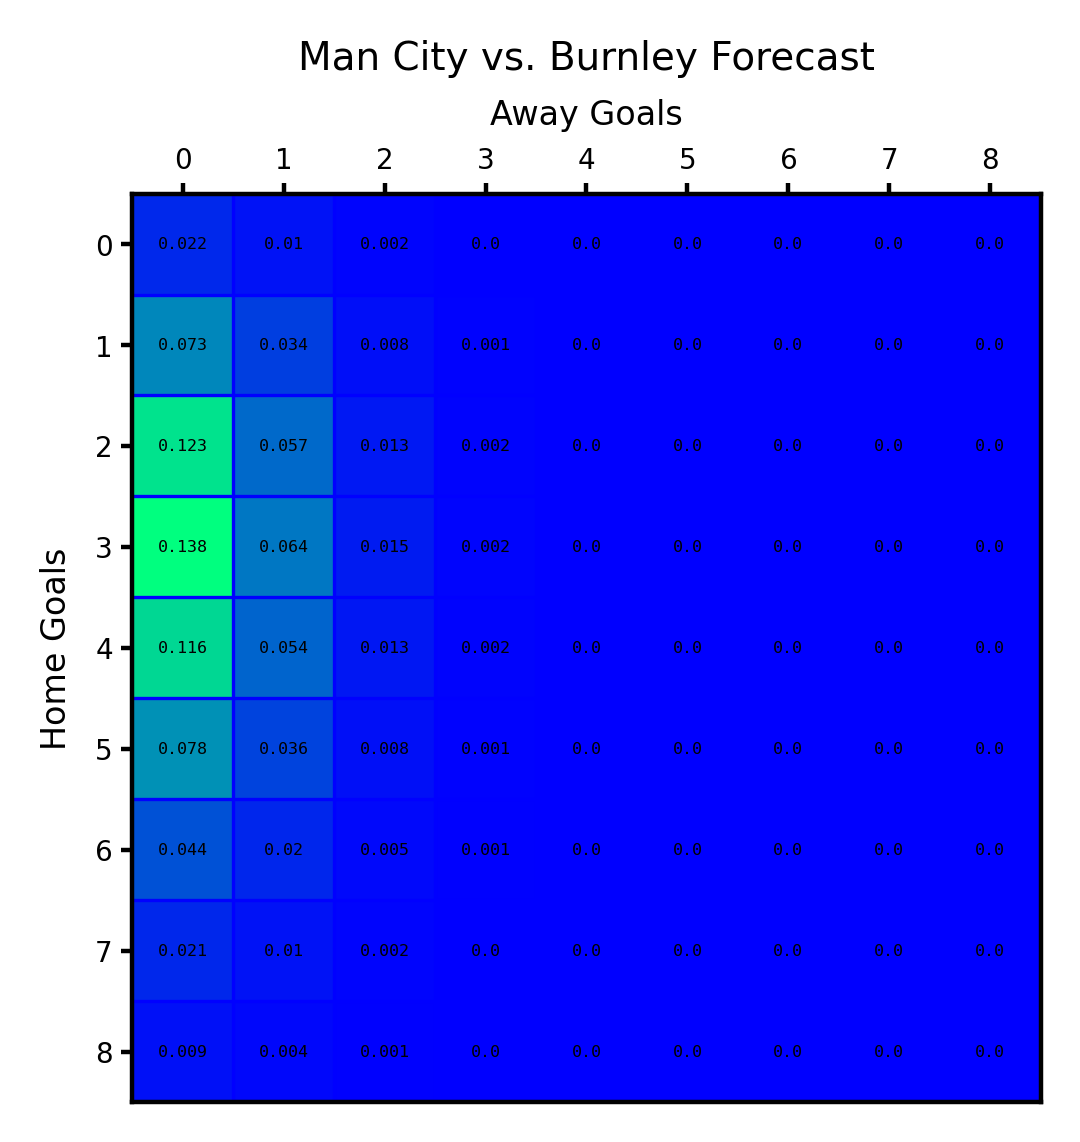

In [44]:
def goal_matrix(homeTeam, awayTeam):
    
    x = simulate_match(homeTeam, awayTeam)
    
    # *Match the plotting functions to the max goals
    # Axes labels
    goals = [0, 1, 2, 3, 4, 5, 6, 7, 8]

    # Plot figure
    fig, ax = plt.subplots(figsize=(3, 3), dpi=400)
    fig.tight_layout()
    im = ax.imshow(x, cmap="winter")

    # Add grid
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(axis='both', which='minor', color='w', length=0)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=0.6)  

    # Set ticks and paremeters
    ax.set_yticks(np.arange(len(goals)))
    ax.set_yticklabels(goals, fontsize=5)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(goals)))
    ax.set_xticklabels(goals, fontsize=5)

    ax.tick_params(axis='both', which='major', length=2, pad=1.5)

    ax.set_ylabel('Home Goals', fontsize=6) # axes label (y)
    ax.set_xlabel('Away Goals', fontsize=6)
    ax.xaxis.set_label_position('top')

    # * Set this to the Home vs Away teams
    ax.set_title('Chelsea vs Sunderland Forecast',fontsize=7, y=1.1)
    ax.set_title(str(homeTeam) + " vs. " + str(awayTeam) + " Forecast",fontsize=7, y=1.1)

    # *rename this variable
    # Rounding probabilites to add to the plot
    rounded = x.tolist()
    rounded3 = []
    for z in rounded:
        rounded2 = [round(x, 3) for x in z]
        rounded3.append(rounded2)
    rounded3 = np.array(rounded3)

    for i in range(len(goals)):
        for j in range(len(goals)):
            text = ax.text(j, i, rounded3[i, j],
                           ha="center", va="center", color="black", fontsize=3,
                           fontfamily='monospace')

    plt.show()
    
    
goal_matrix('Man City', 'Burnley')

In [68]:
# Define a function to get the seasons fixtures from csv
def get_epl_fixtures(season):
    """
    Takes in season formatted as YYYY (First Year of the season)
    """
    #x = pd.read_csv("https://fixturedownload.com/download/csv/epl-" + str(season)) # input season year within hyperlink
    x = pd.read_csv("https://fixturedownload.com/download/epl-" +str(season) + "-GMTStandardTime.csv") # input season year within hyperlink
    
    x = x[['Round Number','Home Team','Away Team','Result', 'Date']] # isolate required columns
    x = x.rename(columns={'Round Number': 'GW', 'Home Team': 'HomeTeam', 'Away Team':'AwayTeam'})
    globals()["epl_fixtures_"+str(season)] = x
    
    return globals()["epl_fixtures_"+str(season)]

In [69]:
get_epl_fixtures(2021)

,GW,HomeTeam,AwayTeam,Result,Date
0,1,Brentford,Arsenal,2 - 0,13/08/2021 20:00
1,1,Man Utd,Leeds,5 - 1,14/08/2021 12:30
2,1,Burnley,Brighton,1 - 2,14/08/2021 15:00
3,1,Chelsea,Crystal Palace,3 - 0,14/08/2021 15:00
4,1,Everton,Southampton,3 - 1,14/08/2021 15:00
...,...,...,...,...,...
375,38,Crystal Palace,Man Utd,NaN,22/05/2022 16:00
376,38,Leicester,Southampton,NaN,22/05/2022 16:00
377,38,Liverpool,Wolves,NaN,22/05/2022 16:00
378,38,Man City,Aston Villa,NaN,22/05/2022 16:00


In [85]:
# Get this weeks fixtures
epl_fixtures_2021[50:60][:]

,GW,HomeTeam,AwayTeam,Result,Date
50,6,Chelsea,Man City,NaN,25/09/2021 12:30
51,6,Man Utd,Aston Villa,NaN,25/09/2021 12:30
52,6,Everton,Norwich,NaN,25/09/2021 15:00
53,6,Leeds,West Ham,NaN,25/09/2021 15:00
54,6,Leicester,Burnley,NaN,25/09/2021 15:00
55,6,Watford,Newcastle,NaN,25/09/2021 15:00
56,6,Brentford,Liverpool,NaN,25/09/2021 17:30
57,6,Southampton,Wolves,NaN,26/09/2021 14:00
58,6,Arsenal,Spurs,NaN,26/09/2021 16:30
59,6,Crystal Palace,Brighton,NaN,27/09/2021 20:00


#### Season Standings

https://www.rotowire.com//soccer/tables/standings.php?league=EPL&length=total&season=2019

https://www.rotowire.com/soccer/league-table.php?season=2018

### Next Steps

Build on the baseline.

Participate in the competition.